<img align="right" src="../additional_data/banner.png" style="width:1100px;">

# Forest inventory

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from your browser
* **Compatibility:** Notebook currently compatible with the Open Data Cube environments of the University of Wuerzburg
* **Prerequisites**: Users should review the [mosaic-](mosaic.ipynb), [export_geotiff-](export_geotiff.ipynb) notebook for more information about the basic steps for any given temporal and spatial combination. An understanding of the underlying data is important for creating a valid mosaic for further analyses.

### Background

Forests are complex biomes. Anaylzing them is an important task to enhance the understanding, also in the context of the current global change. Forests have an important role, e.g. econmical or as carbon sink, which can also be conenected to monetary aspects (CO2 certificates). Furhter societal benefits are in the context of healthcare, e.g. allergies or considering upcoming zoonoses like the Covid-19 pandemic as well as forests role in recreation.


This example tries to demonstrate a potential workflow from loading and processing (cloud removal, median-mosaicing, index calculation) satellite raster-data togehter with additional on-demand vector-data nd export them as cloud-optimized-geotiff for individual processing, e.g. in a local GIS.

### Preliminary steps

In [135]:
# Supress Warning
import warnings
warnings.filterwarnings('ignore')
# Import geopandas package with shortcut 'gpd'
import geopandas as gpd
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'forest_inventory', config = '/home/datacube/.datacube.conf')
import sys

### Loading your area of interest as sahepfile (here: different conservation zones in Rhoen Highlands)

In [136]:
#rhoen = gpd.read_file('MDPI/ONE/biosphaerenreservate_epsg25832_shp.shp')

In [137]:
#rhoen = gpd.read_file('Webinar_26.11.2020/biosphere.geojson')

### Alternative, create your area of interest

Here we load a map visualisation package called 'folium' and a plugin for drawing:

In [138]:
# needed extra packages 
import folium
from folium.plugins import Draw

In [139]:
# define polygon style
style = {'fillColor': '#ffffffff', 'color': '#000000'}

# open map 'm' with defined center and zomm level
m = folium.Map([50.22, 9.84], zoom_start=12)#, tiles='Stamen Terrain')

# load esris satellite map
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

# add geojson
#folium.GeoJson(rhoen.to_json(), style_function=lambda x: style, name="rhoen").add_to(m)

# load openstreet map
folium.TileLayer('openstreetmap').add_to(m)

# load terrain map
folium.TileLayer('Stamen Terrain').add_to(m)

# add lat/lon popup after click on maps
folium.LatLngPopup().add_to(m)

#
#folium.ClickForMarker().add_to(m)
# open layer control in upper right corner of the map
folium.LayerControl().add_to(m)
# draw plugin
Draw(
    export=True,
    filename='my_data.geojson',
    position='topleft',
    draw_options={'polyline': {'allowIntersection': False}},
    edit_options={'poly': {'allowIntersection': False}}
).add_to(m)
m

In [140]:
from pyproj import CRS
from shapely.geometry import Polygon, shape
# copy and paste coordinates
y_min = 50.201579
y_max = 50.234945
x_min = 9.803624
x_max = 9.865099
# sort them to latitude and longitude 
lat_point_list = [y_min, y_max, y_max, y_min, y_min]
lon_point_list = [x_min, x_min, x_max, x_max, x_min]
# build a WGS84 polygon for dispalying on webmap
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
crs = CRS('EPSG:4326')
rhoen_deg = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
# and using regional UTM projection
rhoen_utm = rhoen_deg.to_crs('EPSG:25832')
# and extract regional UTM coordintes
minx = rhoen_utm.bounds.iloc[0,0]
maxx = rhoen_utm.bounds.iloc[0,2]
miny = rhoen_utm.bounds.iloc[0,1]
maxy = rhoen_utm.bounds.iloc[0,3]

## Load Sentinel-2 data from the datacube

Here we are loading a timeseries of `Sentinel-2` satellite images through the datacube API. (official coordinate system ['EPSG:25832'](https://www.ldbv.bayern.de/file/pdf/12867/Faltblatt_UTM-Umstellung.pdf))

In [141]:
# Create query variables
product = 's2_l2a_bavaria'
x_min = minx
x_max = maxx
y_min = miny
y_max = maxy
cosy = 'EPSG:25832'
time_extent = ('2016-01-01', '2016-12-31')

In [142]:
# Load data
dataset = dc.load(product=product,
                  y= (y_min, y_max),
                  x=(x_min, x_max),
                  crs=cosy,
                  time=time_extent)

In [147]:
# dsplay an overview of the data
dataset

<xarray.Dataset>
Dimensions:          (time: 68, x: 443, y: 377)
Coordinates:
  * time             (time) datetime64[ns] 2016-01-03T10:33:20 ... 2016-12-31...
  * y                (y) float64 5.565e+06 5.565e+06 ... 5.561e+06 5.561e+06
  * x                (x) float64 5.573e+05 5.573e+05 ... 5.617e+05 5.617e+05
    spatial_ref      int32 25832
Data variables:
    coastal_aerosol  (time, y, x) int16 7742 7742 7742 7326 ... 4628 4749 4749
    blue             (time, y, x) int16 6975 7007 6744 6559 ... 4372 4296 4496
    green            (time, y, x) int16 6279 6295 6011 5908 ... 4108 4068 4196
    red              (time, y, x) int16 6120 6095 5872 5862 ... 4100 4132 4096
    red_edge1        (time, y, x) int16 6573 6305 6305 6027 ... 3954 4088 4088
    red_edge2        (time, y, x) int16 6389 6159 6159 5878 ... 3968 4135 4135
    red_edge3        (time, y, x) int16 6348 6066 6066 5762 ... 4008 4189 4189
    nir              (time, y, x) int16 6217 6174 6020 5793 ... 4440 4444 4588
    narrow_nir       (time, y, x) int16 6182 6020 6020 5769 ... 4043 4208 4208
    water_vapour     (time, y, x) int16 7353 7353 7353 6381 ... 3967 4025 4025
    swir1            (time, y, x) int16 3388 3204 3204 3054 ... 3656 3839 3839
    swir2            (time, y, x) int16 2327 2114 2114 1957 ... 3446 3627 3627
    scl              (time, y, x) uint8 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9 9
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

### Plot an rgb image to confirm we have data

The 'time' dimension above (68) shows the number of observations and is also the range that can be choosen, considering that Python starst counting with `0`, so we can choose between 0 and 67.

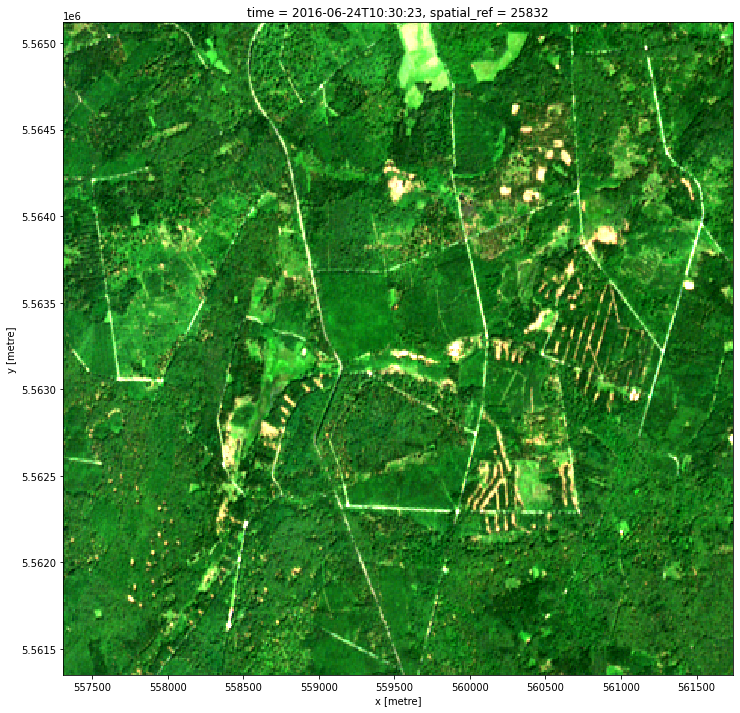

In [159]:
sys.path.append('/datacube/data_cube_notebooks/datacube/Scripts')
from DEAPlotting import rgb

rgb(dataset, index=[30], percentile_stretch=(0.01, 0.99), size=12)

### Add a new 'measurements', i.e. measurment ratios, to the data

You can find a big overview of indices here: <br> https://www.indexdatabase.de

Here we use a simple ratio (SR) and a normalized difference vegetation index (NDVI) and add them to the dataset.

In [160]:
SR = (dataset.narrow_nir / dataset.red)
NDVI = (dataset.narrow_nir - dataset.red)/(dataset.narrow_nir + dataset.red)

dataset['ndvi'] = NDVI
dataset['sr'] = SR

We can control if there are new entries in 'dataset'

In [161]:
dataset

<xarray.Dataset>
Dimensions:          (time: 68, x: 443, y: 377)
Coordinates:
  * time             (time) datetime64[ns] 2016-01-03T10:33:20 ... 2016-12-31...
  * y                (y) float64 5.565e+06 5.565e+06 ... 5.561e+06 5.561e+06
  * x                (x) float64 5.573e+05 5.573e+05 ... 5.617e+05 5.617e+05
    spatial_ref      int32 25832
Data variables:
    coastal_aerosol  (time, y, x) int16 7742 7742 7742 7326 ... 4628 4749 4749
    blue             (time, y, x) int16 6975 7007 6744 6559 ... 4372 4296 4496
    green            (time, y, x) int16 6279 6295 6011 5908 ... 4108 4068 4196
    red              (time, y, x) int16 6120 6095 5872 5862 ... 4100 4132 4096
    red_edge1        (time, y, x) int16 6573 6305 6305 6027 ... 3954 4088 4088
    red_edge2        (time, y, x) int16 6389 6159 6159 5878 ... 3968 4135 4135
    red_edge3        (time, y, x) int16 6348 6066 6066 5762 ... 4008 4189 4189
    nir              (time, y, x) int16 6217 6174 6020 5793 ... 4440 4444 4588
    narrow_nir       (time, y, x) int16 6182 6020 6020 5769 ... 4043 4208 4208
    water_vapour     (time, y, x) int16 7353 7353 7353 6381 ... 3967 4025 4025
    swir1            (time, y, x) int16 3388 3204 3204 3054 ... 3656 3839 3839
    swir2            (time, y, x) int16 2327 2114 2114 1957 ... 3446 3627 3627
    scl              (time, y, x) uint8 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9 9
    ndvi             (time, y, x) float64 0.00504 -0.006191 ... 0.009113 0.01349
    sr               (time, y, x) float64 1.01 0.9877 1.025 ... 1.018 1.027
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

## Masking out clouds
Loading needed functions first

In [85]:
#from s2fn import s2_unpack_scl
import xarray as xr
from xarray.ufuncs import logical_and as xr_and
from xarray.ufuncs import logical_or  as xr_or
import numpy as np
import pandas as pd
from functools import partial 

def s2_scl_clean_mask(dataset, cover_types=['vegetation', 'vegetation']):# here, masking everything instead of scl 'vegetation'
    clean_mask = None
    # Keep all specified cover types (e.g. 'clear', 'water'), so logically or the separate masks.
    for i, cover_type in enumerate(cover_types):
        cover_type_clean_mask = s2_unpack_scl(dataset.scl, cover_type)
        clean_mask = cover_type_clean_mask if i == 0 else xr_or(clean_mask, cover_type_clean_mask)
    return clean_mask

def unpack_s2bits(s2_scl_endcoding, data_array, cover_type):
    boolean_mask = np.isin(data_array.values, s2_scl_endcoding[cover_type]) 
    return xr.DataArray(boolean_mask.astype(bool),
                        coords = data_array.coords,
                        dims = data_array.dims,
                        name = cover_type + "_mask",
                        attrs = data_array.attrs)

def s2_unpack_scl(data_array , cover_type):
    s2_scl_endcoding = dict(no_data                       =[0],
                                saturated_or_defective        =[1],
                                dark_area_pixels              =[2],
                                cloud_shadows                 =[3],
                                vegetation                    =[4],
                                not_vegetated                 =[5],
                                water                         =[6],
                                unclassified                  =[7],
                                cloud_medium_probability      =[8],
                                cloud_high_probability        =[9],
                                thin_cirrus                   =[10],
                                snow                          =[11],
                                cloud                         =[3,8,9,10],
                                cloud_free                    =[4,5,6]
                               )
    return unpack_s2bits(s2_scl_endcoding, data_array, cover_type)

def s2_clean_mask(ds, bands):
    masks = [s2_unpack_scl(ds, band) for band in bands]
    return np.logical_or(*masks).values

def s2_cct(dataset):
    times  = list(dataset.time.values)
    scene_slice_list = list(map(lambda t: dataset.sel(time = t).scl, times))
    clean_mask_list = list(map(partial(s2_clean_mask, bands = ['vegetation','vegetation']), scene_slice_list))
    clean_pixel_count_list = list(map(np.sum, clean_mask_list))
    percentage_list = list(map(lambda x:np.sum(x)/(x.shape[0] * x.shape[1] * 0.01), clean_mask_list))

    data = {"Acquisition time": times,
            "Vegetation [%]": percentage_list,
            "Vegetation pixel [n]": clean_pixel_count_list }
    
    return pd.DataFrame(data=data, columns = ["Acquisition time", "Vegetation [%]", "Vegetation pixel [n]"])



### Make a vegetation overview
Write new variable 'cloudtable' using the defined function s2_cct

In [162]:
cloudtable = s2_cct(dataset)
# print the table
#cloudtable

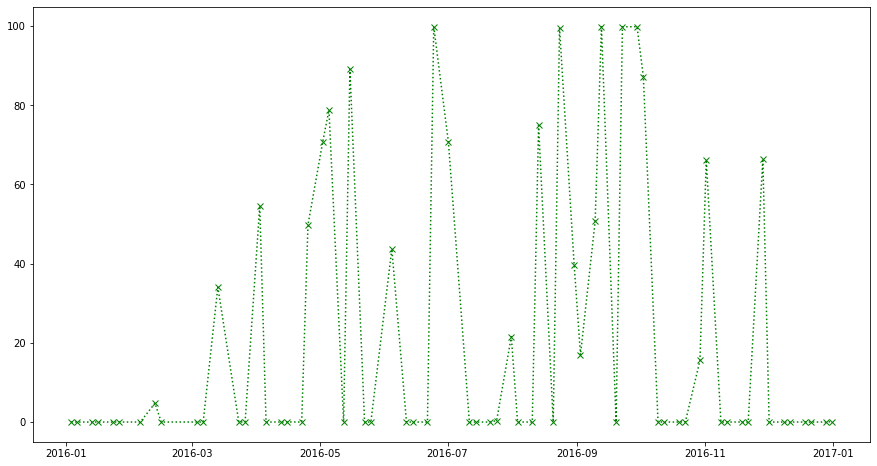

In [163]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,8))
plt.plot(cloudtable["Acquisition time"].values, cloudtable["Vegetation [%]"].values, 'gx:', markersize=6)
plt.show()

### Mask data

Use again the previous defined functions to write the 'cloud_mask'

In [164]:
cloud_mask = s2_scl_clean_mask(dataset)

And use the mask to write 'cleaned_dataset'. The 'cleaned_dataset' here only carries pixels classified as vegetation.

In [165]:
cleaned_dataset = dataset.where(cloud_mask)

In [167]:
cleaned_dataset

<xarray.Dataset>
Dimensions:          (time: 68, x: 443, y: 377)
Coordinates:
  * time             (time) datetime64[ns] 2016-01-03T10:33:20 ... 2016-12-31...
  * y                (y) float64 5.565e+06 5.565e+06 ... 5.561e+06 5.561e+06
  * x                (x) float64 5.573e+05 5.573e+05 ... 5.617e+05 5.617e+05
    spatial_ref      int32 25832
Data variables:
    coastal_aerosol  (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    blue             (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    green            (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    red              (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    red_edge1        (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    red_edge2        (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    red_edge3        (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    nir              (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    narrow_nir       (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    water_vapour     (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    swir1            (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    swir2            (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    scl              (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    ndvi             (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    sr               (time, y, x) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

## Generating median mosaics
### Annual, using 'cleaned_dataset'

This method masks clouds from imagery using the median of the cloud-free pixels in the time series.

In [168]:
from data_cube_utilities.dc_mosaic import create_median_mosaic
median_composite = create_median_mosaic(cleaned_dataset, cloud_mask)

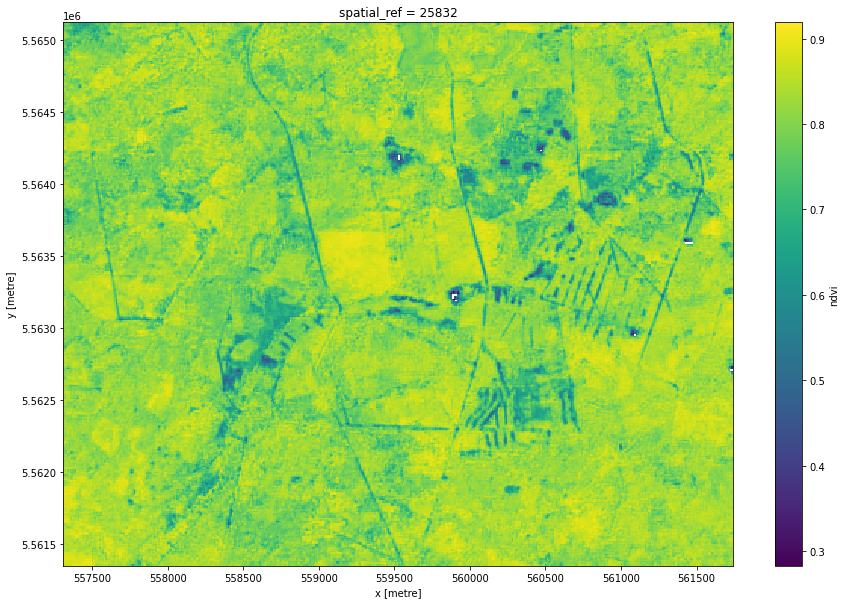

In [174]:
# Plot single bands, with <dataset_name>.<band_name>.plot(size=<integer>)
#median_composite.nir.plot(size=10) # for NIR band
median_composite.ndvi.plot(size=10) # SR
# ...


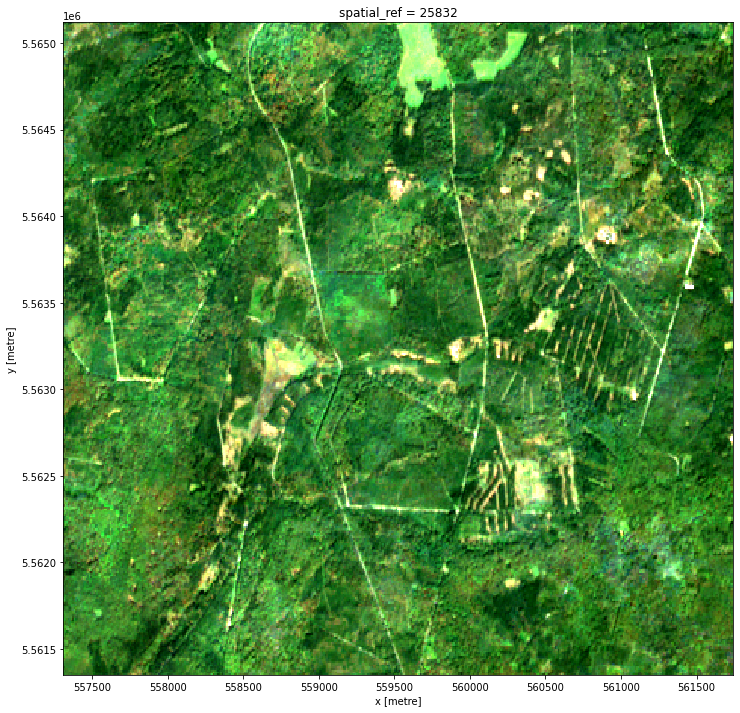

In [173]:
# Plot three-band-composite
# Also try changing the percentile stretch
rgb(median_composite, bands=['red','green','blue'], percentile_stretch = (0.01,0.99), size = 12)
# False color
#rgb(median_composite, bands=['nir', 'red', 'green'], percentile_stretch = (0.01,0.99), size = 12)

### Seasonal, using slices of 'cleaned_dataset'

In [183]:
clean_one = cleaned_dataset.sel(time=slice('2016-01-01', '2016-03-31'))
#clean_two = cleaned_dataset.sel(time=slice('2016-04-01', '2016-06-31'))
#clean_three = cleaned_dataset.sel(time=slice('2016-07-01', '2016-09-30'))
#clean_four = cleaned_dataset.sel(time=slice('2016-10-01', '2016-12-31'))
clean_one

<xarray.Dataset>
Dimensions:          (time: 14, x: 443, y: 377)
Coordinates:
  * time             (time) datetime64[ns] 2016-01-03T10:33:20 ... 2016-03-26...
  * y                (y) float64 5.565e+06 5.565e+06 ... 5.561e+06 5.561e+06
  * x                (x) float64 5.573e+05 5.573e+05 ... 5.617e+05 5.617e+05
    spatial_ref      int32 25832
Data variables:
    coastal_aerosol  (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    blue             (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    green            (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    red              (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    red_edge1        (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    red_edge2        (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    red_edge3        (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    nir              (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    narrow_nir       (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    water_vapour     (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    swir1            (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    swir2            (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    scl              (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    ndvi             (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    sr               (time, y, x) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

In [184]:
from data_cube_utilities.dc_mosaic import create_median_mosaic
median_composite = create_median_mosaic(clean_one, cloud_mask)

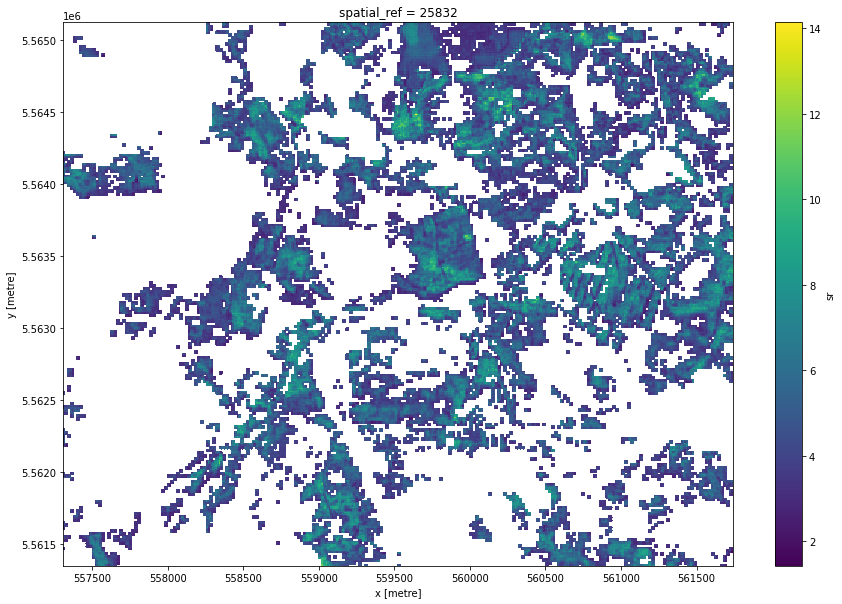

In [186]:
# Plot single bands, with <dataset_name>.<band_name>.plot(size=<integer>)
#median_composite.nir.plot(size=10) # for NIR band
median_composite.sr.plot(size=10) # 
# ...


## Export to anything
This can be done by using the rgb() function